# Here we aim to implement the method of EVI (Epidemic Volatility Index) in python 

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
import itertools
import math
import warnings
warnings.filterwarnings("ignore")

# Read the data

In [3]:
# Data used in the visualization

#df = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/aesop_2025_03_24_mun_new.parquet')

df = pd.read_parquet('/opt/storage/refined/aesop/visualization/aesop_2025_03_26_mun_new.parquet')

In [4]:
# Filter important columns

df = df[['co_uf', 'nm_uf', 'co_ibge7', 'nm_municipio','sigla_uf', 'co_ibge', 
    'epiyear', 'epiweek','year_week','year_week_ts','epidemi_cal_start','epidemi_cal_end',
   'atend_ivas', 'atend_arbov','num_otc_ivas',]]

# Simple EVI implementation

EVI is calculated for a rolling window of time series epidemic data (i.e. the number of new cases per week). At each step, the observations within the window are obtained by shifting the window forward over the time series data one observation at a time. 

Let $x_i=\left\{x_1,\;x_2,...,x_n\right\}$ be a time series of length N. The rolling window size - that is the number of consecutive observations per rolling window - is m. With $0<m\le m_{max}$ and $0<m_{max}\le N$, there are  $t = N - m + 1$ consecutive rolling windows. 

At each of the t steps, EVI uses the standard deviation $\left(s_t\right)$ of the newly reported cases $\left(y_{j_t}=\left\{y_{1_t},\;y_{2_t},...\;,y_{m_t}\right\}\right)$ within the specified m

$$s_t=\sqrt{\frac{1}{m}\sum_{i_t=1}^{m}\left(x_{i_t}-{\overline{x}}_t\right)^2}$$

with $\overline{x_t}$ the mean of the $t^{th}$ window. Subsequently, EVI is calculated as the relative change of $\left(s_t\right)$ between two consecutive rolling windows:

$$EVI_{t-1,t}=\frac{s_t-s_{t-1}}{s_{t-1}}$$

We expect an increase in the future number of cases, if $EVI_{t-1,t}$ exceeds a threshold c $\left(c\in\left[0,1\right]\right)$ and the observed cases at time point t,$\left(y_t\right)$ are higher than the average of the reported cases in the previous week:

$$Ind_{EVI_{t-1,t}}=\left\{\begin{matrix} 1 & if & E V I_{t-1,t}\geq c \ and \  y_t\geq{\overline{\mu}}_{t:t-7}\\
                                          0 & otherwise\\
                                          \end{matrix}\right.$$


In the new method, we use the results before to define an upper bound using EVI such that:

1. Observations with $ Ind = 1 $ (warnings) exceed this upper bound.
2. Observations with $ Ind = 0 $ (no warnings) fall below this bound.

### Defining an Upper Bound

A nupper bound limit can be expressed in terms of $ s_t $ and $ EVI_{t-1,t} $, ensuring that it captures anomalies detected by your model.

Since $ EVI_{t-1,t} $ represents the relative change in standard deviation, a natural threshold can be set based on how much the standard deviation increases. We can define an upper bound $ U_t $ as:

$$
U_t = \overline{x}_t + k \cdot s_t
$$

where $ k $ is a multiplier that ensures the bound is exceeded when $ Ind = 1 $.

#### Estimating $ k $ from $ EVI $ Threshold
From our model definition:
- $ Ind = 1 $ when $ EVI_{t-1,t} \geq c $, meaning $ s_t $ has increased significantly.
- Also, $ y_t $ must be greater than the mean over the last 7 days.

To incorporate $ EVI $, we can express $ s_t $ in terms of its previous value:

$$
s_t = (1 + EVI_{t-1,t}) s_{t-1}
$$

Using this, we can set the bound as:

$$
U_t = \overline{x}_t + k (1 + c) s_{t-1}
$$

where $ c $ is your model's detection threshold.

#### Optimizing $ k $
To determine $ k $, we can empirical estimatimate this parameter from data by computing the ratio 

$$ k = \frac{y_t - \overline{x}_t}{(1 + c) s_{t-1}} $$

In [87]:
def func(m, series, r_a, mu, c):
    """
    This function calculates the EVIt-1,t and adds an upper bound limit (Ut) to detect anomalies.
    
    Parameters:
    m: Rolling window size
    series: The time series data
    r_a: Lag for moving average
    mu: Window size for mean calculation (default is 7)
    c: EVI threshold
    
    Returns:
    DataFrame with calculated values including Ut.
    """
    tseries = pd.Series(series).rolling(window=r_a).mean()
    
    # Compute rolling standard deviation
    std_windows = [tseries[i:m+i].std() for i in range(len(tseries) - m + 1)]
    
    # Compute EVI
    evi_t1_t = (pd.Series(std_windows) - pd.Series(std_windows).shift()) / abs(pd.Series(std_windows).shift())
    evi_t1_t = evi_t1_t.round(2).fillna(0)
    evi_t1_t_2 = [0] * (m-1) + evi_t1_t.to_list()
    
    # Compute mean over last 'mu' points
    mean_windows = [series[i:mu+i].mean() for i in range(len(series) - mu + 1)]
    mu_ = [0] * (mu-1) + mean_windows
    
    # Create DataFrame
    data = pd.DataFrame({'series': series, 'tseries': tseries, 'evi_t1_t': evi_t1_t_2, 'mu': mu_})
    data['st'] = [None] * (len(series) - len(std_windows)) + std_windows  # Fill previous values
    
    # Categorization based on thresholds
    data['cat_mu'] = 0
    data.loc[(data['series'] >= 0.75 * data['mu']) & (data['series'] < data['mu']), 'cat_mu'] = 0.5
    data.loc[(data['series'] >= data['mu']), 'cat_mu'] = 1
    
    data['cat_evi'] = (data['evi_t1_t'] >= c).astype(int)
    
    data['ind'] = 0
    data.loc[(data['cat_evi'] == 1) & (data['cat_mu'] == 1), 'ind'] = 1
    
    data['ind_2'] = 0
    data.loc[(data['evi_t1_t'] >= 0) & (data['evi_t1_t'] <= c) & (data['cat_mu'] >= 0.5), 'ind_2'] = 0.5
    data.loc[(data['evi_t1_t'] > c) & (data['cat_mu'] == 1), 'ind_2'] = 1
    
    # Compute k dynamically based on 95th percentile
    k_opt = (data['series'] - data['mu']) / ( (1 + c) * data['st'].shift(1))
    
  
    # Compute Upper Bound Ut
    data['Ut'] = data['tseries'] +  abs(k_opt) * (1 + c) * data['st'].shift(1) 
    
    data = data.assign(kf =  abs(k_opt))
    
    data = data.assign(ind3 = (data.series >= data.Ut.fillna(0).astype(int)).astype(int))
    
    return data


In [141]:
df[df.nm_uf == 'Rio Grande do Sul']

,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas
84084,43,Rio Grande do Sul,4300059,Água Santa,RS,430005,2017,1,2017-01,2017-01-02,2017-01-01,2017-01-07,16,0,NaN
84085,43,Rio Grande do Sul,4300059,Água Santa,RS,430005,2017,2,2017-02,2017-01-09,2017-01-08,2017-01-14,12,0,NaN
84086,43,Rio Grande do Sul,4300059,Água Santa,RS,430005,2017,3,2017-03,2017-01-16,2017-01-15,2017-01-21,7,0,NaN
84087,43,Rio Grande do Sul,4300059,Água Santa,RS,430005,2017,4,2017-04,2017-01-23,2017-01-22,2017-01-28,9,0,NaN
84088,43,Rio Grande do Sul,4300059,Água Santa,RS,430005,2017,5,2017-05,2017-01-30,2017-01-29,2017-02-04,10,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2382661,43,Rio Grande do Sul,4322376,Unistalda,RS,432237,2025,8,2025-08,2025-02-17,2025-02-16,2025-02-22,4,0,4.0
2382662,43,Rio Grande do Sul,4322376,Unistalda,RS,432237,2025,9,2025-09,2025-02-24,2025-02-23,2025-03-01,0,0,NaN
2382663,43,Rio Grande do Sul,4322376,Unistalda,RS,432237,2025,10,2025-10,2025-03-03,2025-03-02,2025-03-08,2,0,20.0
2382664,43,Rio Grande do Sul,4322376,Unistalda,RS,432237,2025,11,2025-11,2025-03-10,2025-03-09,2025-03-15,6,0,23.0


In [174]:
code = df[df.nm_municipio == 'Água Santa'].co_ibge7.iloc[0] #Planaltina

set_muni = df[df.co_ibge7 == code]

In [175]:
#func(m, serie,r_a,mu,c1,c2)
dtf = func(5,set_muni.atend_ivas.to_numpy(),4,8,0.2)

In [176]:
dtf.ind3.sum()

88

<Figure size 1500x300 with 0 Axes>

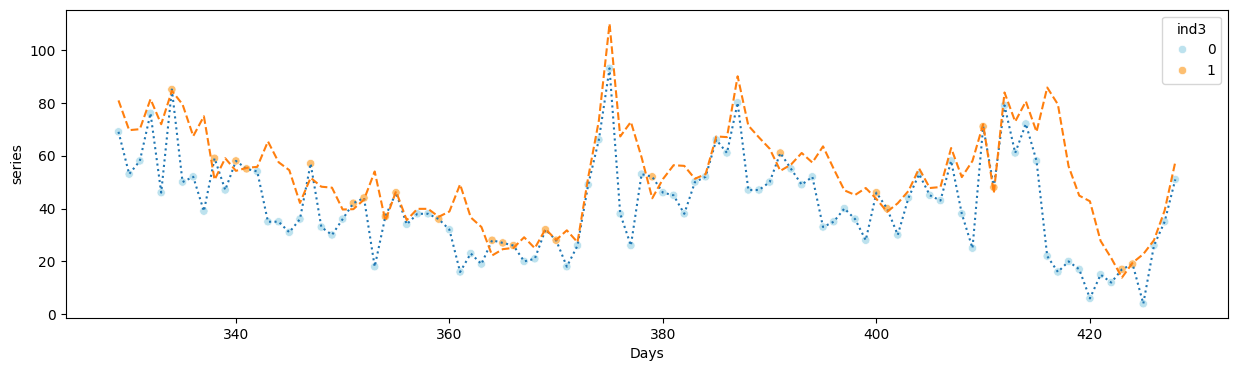

In [177]:
x = list(range(0, len(dtf)))
    
dtf = dtf.assign(Days = x)

fig = plt.figure(figsize =(15, 3))

fig = plt.figure(figsize =(15, 4))
sns.scatterplot(x = "Days", y = "series", data = dtf[-100:], hue = "ind3", palette = "RdYlBu_r") 
#sns.scatterplot(x = "Days", y = "series", data = dtf[-200:], hue = "ind", palette = "Oranges_r") 
plt.plot(x[-100:], dtf[-100:].series,linestyle = ':',label = 'atend')
plt.plot(x[-100:], dtf[-100:].Ut,linestyle = '--',label = 'Ut')

# Run the method for all municipalities and save data with standard format

In [178]:
lst_dfs = []

for code in df.co_ibge7.unique():

    set_muni = df[df.co_ibge7 == code]

    dtf = func(5,set_muni.atend_ivas.to_numpy(),3,8,0.15) #MUDANÇA aqui
    
    set_muni = set_muni.reset_index()
    set_muni = set_muni.assign(tseries = dtf['tseries'],
                               ind = dtf['ind3'],
                               Ut = dtf['Ut'] )
    #set_muni = set_muni.assign(ind2 = dtf['ind_2'])
    #set_muni = set_muni.assign(evi_t1_t = dtf['evi_t1_t'])
    #set_muni = set_muni.assign(mu = dtf['mu'])
    set_muni = set_muni.assign(exc = set_muni['atend_ivas'] - set_muni['Ut'])
    set_muni['exc'][set_muni['exc'] < 0] = 0
    
    lst_dfs.append(set_muni)

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['exc'][set_muni['exc'] < 0] = 0
<ipython-input-180-7064ef3559b7>:17: SettingWithCopyWarning: 
A val

In [179]:
lst_dfs[0]

,index,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas,tseries,ind,Ut,exc
0,0,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2017,1,2017-01,2017-01-02,2017-01-01,2017-01-07,0,0,NaN,NaN,1,NaN,NaN
1,1,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2017,2,2017-02,2017-01-09,2017-01-08,2017-01-14,3,0,NaN,NaN,1,NaN,NaN
2,2,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2017,3,2017-03,2017-01-16,2017-01-15,2017-01-21,5,0,NaN,2.666667,1,NaN,NaN
3,3,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2017,4,2017-04,2017-01-23,2017-01-22,2017-01-28,1,0,NaN,3.000000,1,NaN,NaN
4,4,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2017,5,2017-05,2017-01-30,2017-01-29,2017-02-04,5,0,NaN,3.666667,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,424,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2025,8,2025-08,2025-02-17,2025-02-16,2025-02-22,0,0,3.0,0.000000,1,NaN,NaN
425,425,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2025,9,2025-09,2025-02-24,2025-02-23,2025-03-01,0,0,12.0,0.000000,1,NaN,NaN
426,426,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2025,10,2025-10,2025-03-03,2025-03-02,2025-03-08,0,0,36.0,0.000000,1,NaN,NaN
427,427,11,Rondônia,1101484,São Felipe D'Oeste,RO,110148,2025,11,2025-11,2025-03-10,2025-03-09,2025-03-15,0,0,44.0,0.000000,1,NaN,NaN


In [183]:
df_final = pd.concat(lst_dfs)

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2389530 entries, 0 to 2389529
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   co_uf              int64  
 1   nm_uf              object 
 2   co_ibge7           int64  
 3   nm_municipio       object 
 4   sigla_uf           object 
 5   co_ibge            int64  
 6   epiyear            int64  
 7   epiweek            int64  
 8   year_week          object 
 9   year_week_ts       object 
 10  epidemi_cal_start  object 
 11  epidemi_cal_end    object 
 12  atend_ivas         int64  
 13  atend_arbov        int64  
 14  num_otc_ivas       float64
dtypes: float64(1), int64(7), object(7)
memory usage: 291.7+ MB


In [185]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2389530 entries, 0 to 428
Data columns (total 20 columns):
 #   Column             Dtype  
---  ------             -----  
 0   index              int64  
 1   co_uf              int64  
 2   nm_uf              object 
 3   co_ibge7           int64  
 4   nm_municipio       object 
 5   sigla_uf           object 
 6   co_ibge            int64  
 7   epiyear            int64  
 8   epiweek            int64  
 9   year_week          object 
 10  year_week_ts       object 
 11  epidemi_cal_start  object 
 12  epidemi_cal_end    object 
 13  atend_ivas         int64  
 14  atend_arbov        int64  
 15  num_otc_ivas       float64
 16  tseries            float64
 17  ind                int64  
 18  Ut                 float64
 19  exc                float64
dtypes: float64(4), int64(9), object(7)
memory usage: 382.8+ MB


In [186]:
df_final[(df_final.ind == 0) & (df_final.exc > 0)]

,index,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas,tseries,ind,Ut,exc


In [187]:
df_final[(df_final.ind == 1) & (df_final.exc < 0)]

,index,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas,tseries,ind,Ut,exc


In [188]:
#df_final[(df_final.ind == 1) & (df_final.exc > 0)]

In [189]:
inf_df = df_final[(df_final == np.inf).any(axis=1)]
inf_df

,index,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas,tseries,ind,Ut,exc


In [190]:
dta_teste = df_final[df_final.co_ibge7 == code][['nm_municipio','atend_ivas', 'tseries', 'epiweek', 'year_week',
       'year_week_ts', 'Ut', 'ind',  'exc']][-100:]

In [191]:
dta_teste

,nm_municipio,atend_ivas,tseries,epiweek,year_week,year_week_ts,Ut,ind,exc
329,Rianápolis,80,86.666667,17,2023-17,2023-04-24,91.916667,0,0.000000
330,Rianápolis,58,77.333333,18,2023-18,2023-05-01,103.333333,0,0.000000
331,Rianápolis,31,56.333333,19,2023-19,2023-05-08,102.833333,0,0.000000
332,Rianápolis,57,48.666667,20,2023-20,2023-05-15,63.541667,0,0.000000
333,Rianápolis,91,59.666667,21,2023-21,2023-05-22,81.916667,1,9.083333
...,...,...,...,...,...,...,...,...,...
424,Rianápolis,153,134.000000,8,2025-08,2025-02-17,217.125000,0,0.000000
425,Rianápolis,84,114.666667,9,2025-09,2025-02-24,118.291667,0,0.000000
426,Rianápolis,9,82.000000,10,2025-10,2025-03-03,150.625000,0,0.000000
427,Rianápolis,42,45.000000,11,2025-11,2025-03-10,81.375000,0,0.000000


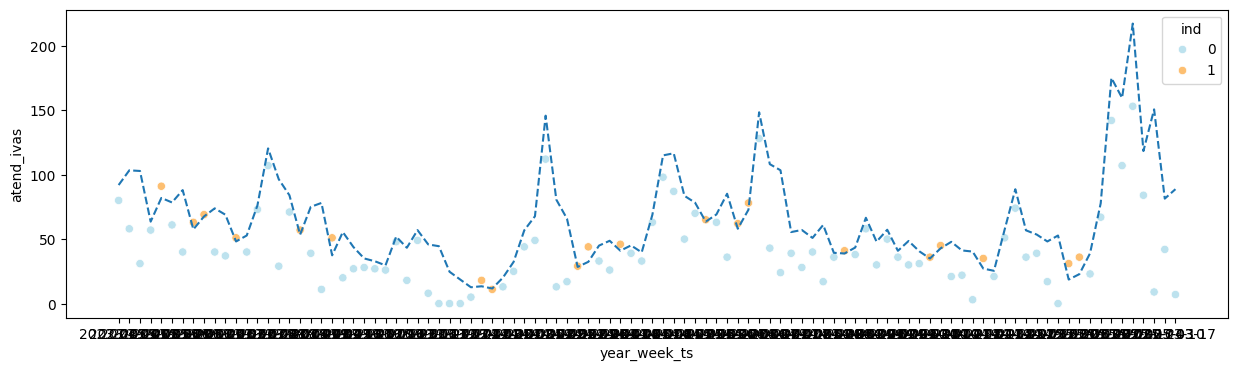

In [192]:
dtf = dta_teste
fig = plt.figure(figsize =(15, 4))
sns.scatterplot(x = "year_week_ts", y = "atend_ivas", data = dtf, hue = "ind", palette = "RdYlBu_r") 
plt.plot(dtf.year_week_ts, dtf.Ut,linestyle = '--',label = 'Ut')


    


# Replace inf values in df_final

In [107]:
df_final[(df_final == np.inf).any(axis=1)]

,index,co_uf,nm_uf,co_ibge7,nm_municipio,sigla_uf,co_ibge,epiyear,epiweek,year_week,year_week_ts,epidemi_cal_start,epidemi_cal_end,atend_ivas,atend_arbov,num_otc_ivas,tseries,ind,Ut,exc


In [24]:
table = pa.Table.from_pandas(df_final)

lin = '/opt/storage/refined/aesop/visualization/PHC/2017_20230910_AESOP_variables2_mod.parquet'


pq.write_table(table, lin)